In [1]:
import fasttext
model = fasttext.load_model('./util/cc.en.300.bin')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import json

from tqdm import tqdm

C:\Users\Baha Tegar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import util.normalization as norm
import util.model as models
import util.utility as util

In [4]:
pd.set_option("display.max_rows", 250)

In [5]:
df = pd.read_csv("./clothes_result/base_clothes.csv")
df = df.fillna(" ")

df['aspect'] = df['aspect'].apply(lambda x: x.split(", "))
df['token_sentence'] = df['token_sentence'].apply(lambda x: x.split('.\n'))
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewer_id     100 non-null    int64 
 1   review          100 non-null    object
 2   summarize       100 non-null    object
 3   aspect          100 non-null    object
 4   token_sentence  100 non-null    object
 5   token_lemma     100 non-null    object
 6   rating          100 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 5.6+ KB
None


,reviewer_id,review,summarize,aspect,token_sentence,token_lemma,rating
0,0,So flattering and so comfortable! I am in love...,So flattering and so comfortable! I am in lov...,"[beige sandal, casual look, compliment, left s...","[It has a relaxed fit style as described, and ...",it have a relaxed fit style as described.\nand...,5
1,1,"Cute but It Pills Great color and pattern, wit...","Material began to pill after first wearing, a...","[great color, material, slouchy look, wash cyc...","[Cute but It Pills Great color and pattern, wi...",cute but it pill great color and pattern.\nwit...,3
2,2,It fell apart after one wash One set fell apar...,One set fell apart after one wash . Threads c...,"[bad thing, string, set, thread, product info,...",[It fell apart after one wash One set fell apa...,it fell apart after one wash one set fell apar...,1
3,3,"Comfortable, nice color, but LOTS of pilling. ...","Comfortable, nice color, but lots of pilling ...","[purchase, good care, nice color, fit, fabric,...","[nice color, I like the fit, weight, I would h...",nice color.\ni like the fit.\nweight.\ni would...,3
4,4,"Cute dress that.even a short, skinny old woman...","Cute dress that.even a short, skinny old woma...","[necessary spot, material, old woman, woman sk...","[Cute dress that.even a short, skinny old woma...",cute dress that.even a short.\nskinny old woma...,5


In [6]:
df_an = df[['reviewer_id', 'aspect']].copy()
df_an.head()

,reviewer_id,aspect
0,0,"[beige sandal, casual look, compliment, left s..."
1,1,"[great color, material, slouchy look, wash cyc..."
2,2,"[bad thing, string, set, thread, product info,..."
3,3,"[purchase, good care, nice color, fit, fabric,..."
4,4,"[necessary spot, material, old woman, woman sk..."


# Coding Process

In [7]:
# map_categorize = {
#     0: 'order and food',
#     1: 'service and time',
#     2: 'order and food',
#     3: 'order and food',
#     4: 'service and time',
#     5: 'order and food',
#     6: 'service and time',
# }

# df['category'] = df['topic'].apply(lambda x: map_categorize[x])

# print(df.info())
# df.head()

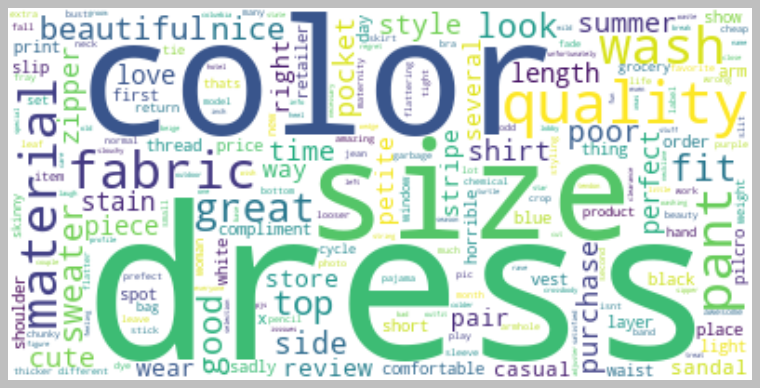

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
aspects = df_an['aspect'].values
for i in range(df_an.shape[0]):
    text = text + " " + " ".join(list(aspects[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
words_count = {}

words = text.split()

for word in words:
    word = word.lower()
    if word in words_count:
        words_count[word] += 1
    else:
        words_count[word] = 1
        
# words_count = dict(
#                 sorted(words_count.items(),
#                        key=lambda x: x[1],
#                        reverse=True))

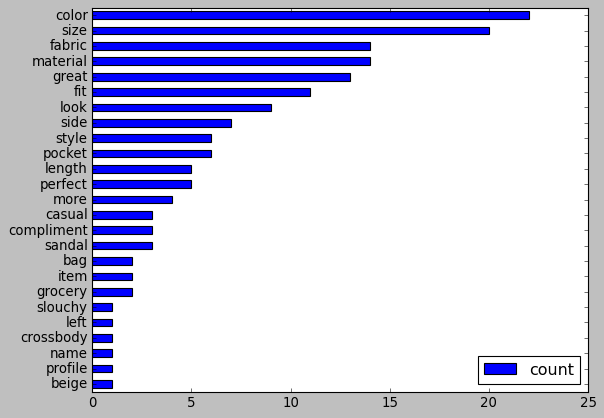

In [10]:
df_word = pd.DataFrame(data=words_count.values(),
                       index=words_count.keys(), 
                       columns=['count'])

df_word.head(25).sort_values(by='count', ascending=True).plot(kind='barh')
plt.show()

2.0


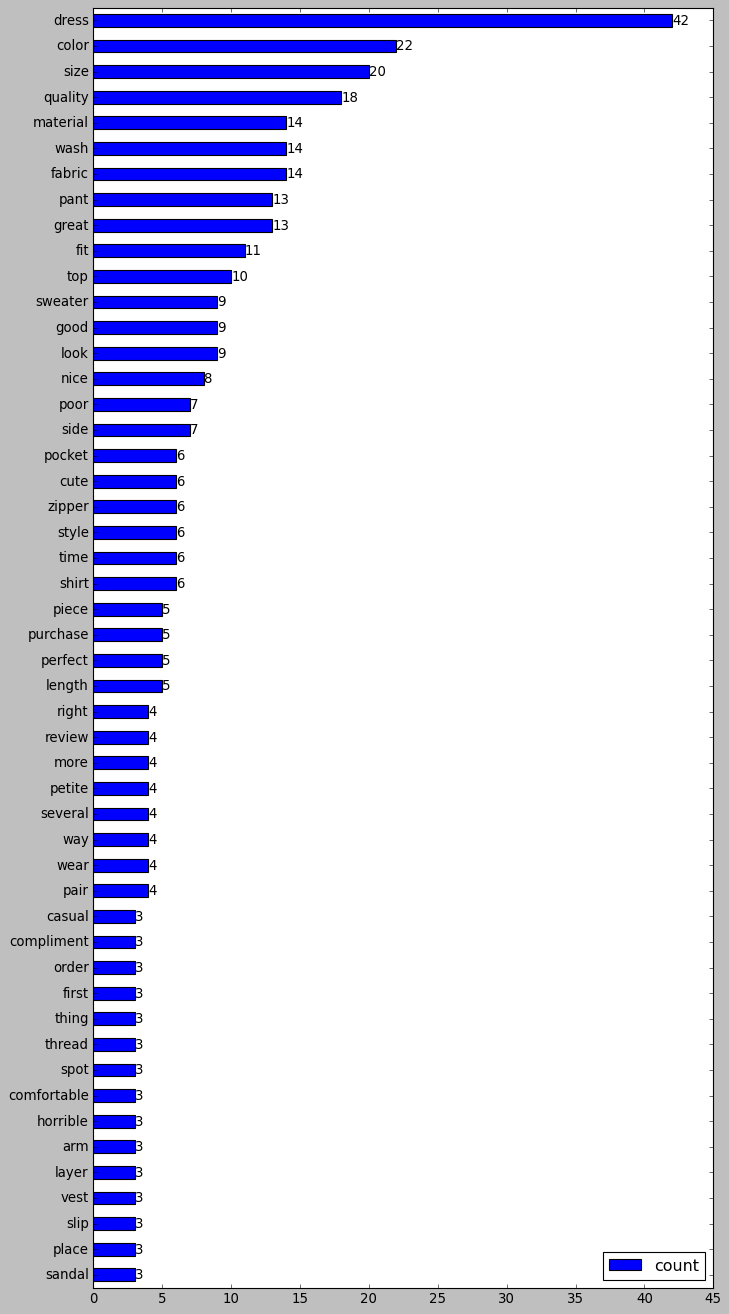

In [11]:
# Show 75% words

threshold = df_word.quantile(q=0.75).iloc[0]
# threshold = 0.25 * df_word.max().iloc[0]
# threshold = df_word.mean().iloc[0]
print(threshold)

df_plot = df_word[df_word['count'] > threshold]\
        .head(50)

ax = df_plot\
        .sort_values(by='count', ascending=True)\
        .plot(kind='barh', figsize=(10, 20))

for container in ax.containers:
    ax.bar_label(container)

plt.show()

## A. First Cycle

In [12]:
list_first_cycle = list(df_word[df_word['count'] > threshold].index)
print(len(list_first_cycle))

# Additional filter
list_first_cycle = [word for word in list_first_cycle if len(word) >= 3]

def first_cycle(x):
    global list_first_cycle
        
    set1 = set(" ".join(x).split(" "))
    set2 = set(list_first_cycle)
    
    temp = set1 & set2
    
    if len(temp) != len(set1):
        temp.add("other")
    return temp

def get_other(x):
    global list_first_cycle
    
    set1 = set(" ".join(x).split(" "))
    set2 = set(list_first_cycle)
    
    temp = set1.difference(set2)
    
    return temp

def get_residu(x):
    texts = x['residu']
    array = x['aspect']

    temp = []
    for text in texts:
        pattern = re.compile(rf"{text}")
        
        result = [element for element in array if pattern.search(element)]
        temp = temp + result

    return set(temp)



tqdm.pandas()
df_an['first_cycle'] = df_an['aspect'].progress_apply(lambda x: first_cycle(x))

df_an['residu'] = df_an['aspect'].progress_apply(lambda x: get_other(x))

df_an['residu'] = [get_residu(x[-1]) for x in df_an.iterrows()]

df_an = df_an.explode('first_cycle').reset_index(drop=True)
df_an

71


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 100007.25it/s]


,reviewer_id,aspect,first_cycle,residu
0,0,"[beige sandal, casual look, compliment, left s...",other,"{more item, profile, grocery, beige sandal, cr..."
1,0,"[beige sandal, casual look, compliment, left s...",compliment,"{more item, profile, grocery, beige sandal, cr..."
2,0,"[beige sandal, casual look, compliment, left s...",perfect,"{more item, profile, grocery, beige sandal, cr..."
3,0,"[beige sandal, casual look, compliment, left s...",length,"{more item, profile, grocery, beige sandal, cr..."
4,0,"[beige sandal, casual look, compliment, left s...",pocket,"{more item, profile, grocery, beige sandal, cr..."
...,...,...,...,...
450,99,"[positive side, tight sleeve, thread, several ...",side,"{shiny band, sleeve opening, band detail, repl..."
451,99,"[positive side, tight sleeve, thread, several ...",piece,"{shiny band, sleeve opening, band detail, repl..."
452,99,"[positive side, tight sleeve, thread, several ...",quality,"{shiny band, sleeve opening, band detail, repl..."
453,99,"[positive side, tight sleeve, thread, several ...",several,"{shiny band, sleeve opening, band detail, repl..."


## B. Second Cycle

In [13]:
map_second_code = {'properties': ['size', 'material', 'fabric', 'product', 'color', 
                                  'weight', 'quality', 'pocket', 'zipper', 'white',], 
                   'experience': ['side', 'spot', 'arm', 'waist', 'fit', 'style', 
                                  'right', 'slip', 'wear', 'stripe', 'length', 'weight',],
                   'emotion': ['nice', 'cute', 'good', 'top', 'poor', 'great', 'few', 
                               'beautiful', 'perfect', 'flattering',], 
                   'service': ['staff', 'customer', 'service', 'location', 'regular', 'time', 'lady', 
                               'experience', 'crew', 'manager', 'employee', 'price', 'management', 'attitude',
                               'work', 'issue',],
                   'application': ['wash', 'store', 'new', 'time', 'summer', 'golf', 'first', 'piece',],
                   'type': ['dress', 'pant', 'vest', 'shirt', 'sweater',] 
                  }

def second_cycle(x):
    temp = set()
    for key in map_second_code.keys():
        if x in map_second_code[key]:
            temp.add(key)
#     if len(temp) == 0:
#         temp.add('other')
        
    return temp


tqdm.pandas()
df_an['second_cycle'] = df_an['first_cycle'].progress_apply(lambda x: second_cycle(x))
# # EXPERIMENT
experiment = df_an[['reviewer_id', 'aspect', 'residu', 'first_cycle', 'second_cycle']].copy()


100%|████████████████████████████████████████████████████████████████████████████| 455/455 [00:00<00:00, 279948.41it/s]


In [14]:
# Extract residu

def extract_residu(x):
    global map_second_code
    
    residu = x['residu']
    first_cycle = x['first_cycle']
    second_keys = list(map_second_code.keys())
    temp = []
    
    if first_cycle != 'other':
        return set()
    
    for s in residu:
        result = util.get_nearest_word(s, second_keys,
                                       model, threshold=.35)
        
        if result:
            temp.append(result)
    return set(temp)

def merge_residu(x):
    set1 = x['second_cycle']
    set2 = x['extract_residu']
    
    result = set1.union(set2)
    
    if len(result) == 0:
        return set(['other'])
    return set1.union(set2)


df_an['extract_residu'] = [extract_residu(x[-1]) for x in df_an.iterrows()]
df_an['second_cycle'] = [merge_residu(x[-1]) for x in df_an.iterrows()]


df_an = df_an.explode('second_cycle').reset_index(drop=True).drop('extract_residu', axis=1)

df_an

,reviewer_id,aspect,first_cycle,residu,second_cycle
0,0,"[beige sandal, casual look, compliment, left s...",other,"{more item, profile, grocery, beige sandal, cr...",type
1,0,"[beige sandal, casual look, compliment, left s...",compliment,"{more item, profile, grocery, beige sandal, cr...",other
2,0,"[beige sandal, casual look, compliment, left s...",perfect,"{more item, profile, grocery, beige sandal, cr...",emotion
3,0,"[beige sandal, casual look, compliment, left s...",length,"{more item, profile, grocery, beige sandal, cr...",experience
4,0,"[beige sandal, casual look, compliment, left s...",pocket,"{more item, profile, grocery, beige sandal, cr...",properties
...,...,...,...,...,...
457,99,"[positive side, tight sleeve, thread, several ...",side,"{shiny band, sleeve opening, band detail, repl...",experience
458,99,"[positive side, tight sleeve, thread, several ...",piece,"{shiny band, sleeve opening, band detail, repl...",application
459,99,"[positive side, tight sleeve, thread, several ...",quality,"{shiny band, sleeve opening, band detail, repl...",properties
460,99,"[positive side, tight sleeve, thread, several ...",several,"{shiny band, sleeve opening, band detail, repl...",other


In [15]:
# Store residu data

residu_frame = df_an.groupby('reviewer_id')['residu']\
                .apply(lambda x: set().union(*x))\
                .reset_index()

residu_frame['residu'] = residu_frame['residu'].apply(lambda x: ", ".join(list(x)))

In [16]:
result = df_an[['reviewer_id', 'first_cycle', 'second_cycle']]\
            .copy()\
            .reset_index()\
            .rename(columns={'index': 'node_id'})

print(result.info())
result.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   node_id       462 non-null    int64 
 1   reviewer_id   462 non-null    int64 
 2   first_cycle   462 non-null    object
 3   second_cycle  462 non-null    object
dtypes: int64(2), object(2)
memory usage: 14.6+ KB
None


,node_id,reviewer_id,first_cycle,second_cycle
0,0,0,other,type
1,1,0,compliment,other
2,2,0,perfect,emotion
3,3,0,length,experience
4,4,0,pocket,properties


## C. Categorizing

In [17]:
map_categorizing = {
    'customer experience': ['experience', 'emotion', 'application'],
    'products': ['properties', 'type'],
}

def final_categorizing(x):
    for key in map_categorizing.keys():
        if x in map_categorizing[key]:
            return key
    return "other"

tqdm.pandas()
result['category'] = result['second_cycle'].progress_apply(lambda x: final_categorizing(x))

100%|████████████████████████████████████████████████████████████████████████████| 462/462 [00:00<00:00, 382731.28it/s]


In [18]:
result

,node_id,reviewer_id,first_cycle,second_cycle,category
0,0,0,other,type,products
1,1,0,compliment,other,other
2,2,0,perfect,emotion,customer experience
3,3,0,length,experience,customer experience
4,4,0,pocket,properties,products
...,...,...,...,...,...
457,457,99,side,experience,customer experience
458,458,99,piece,application,customer experience
459,459,99,quality,properties,products
460,460,99,several,other,other


# Linking Nodes

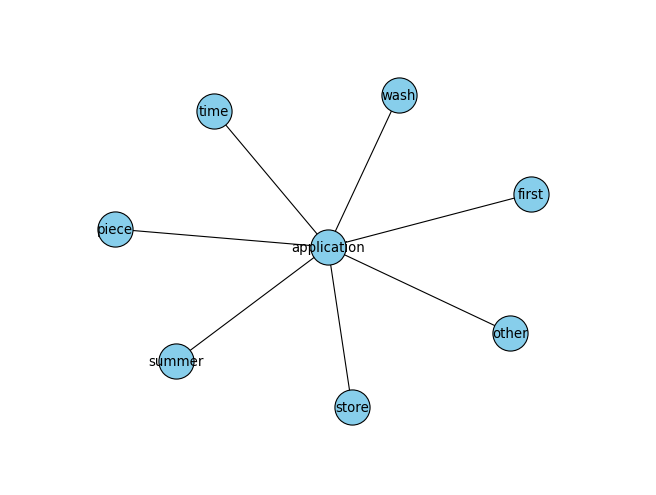

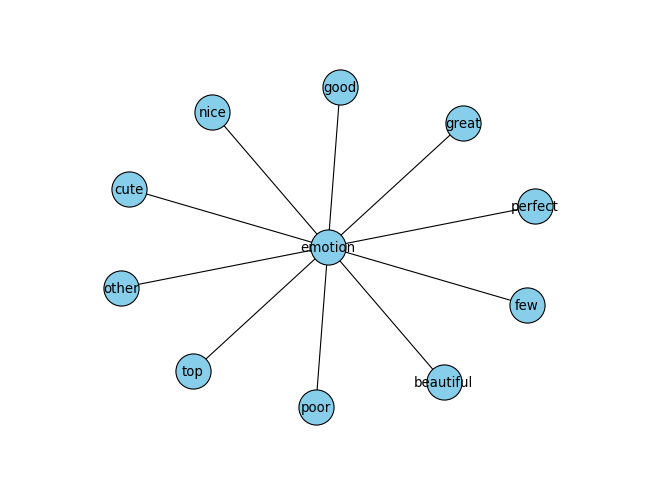

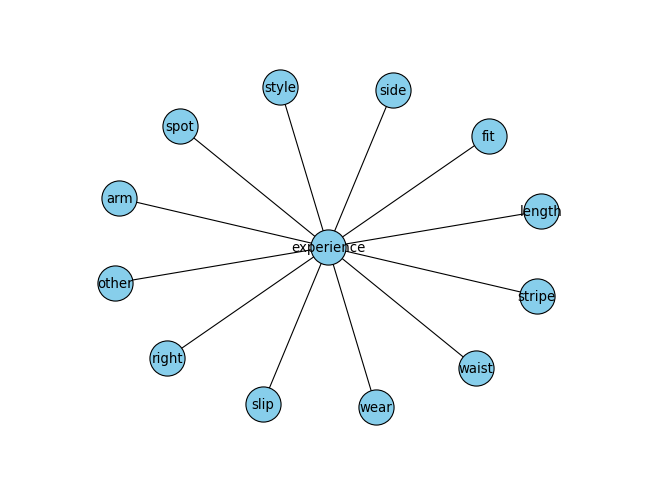

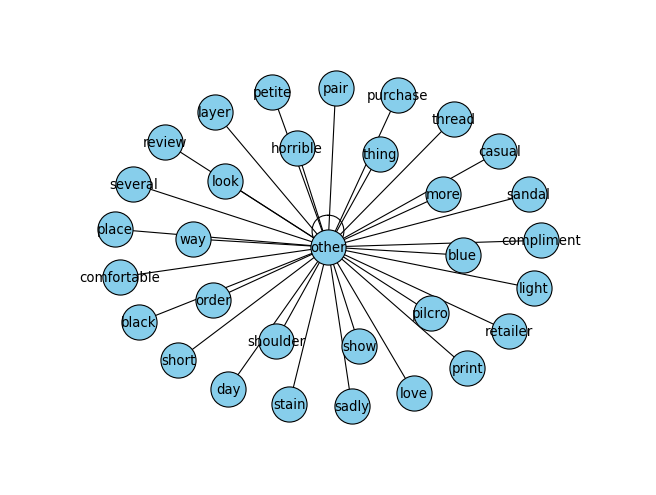

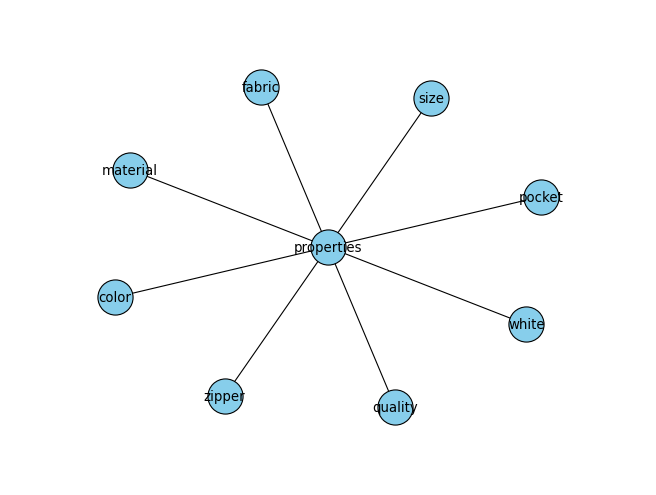

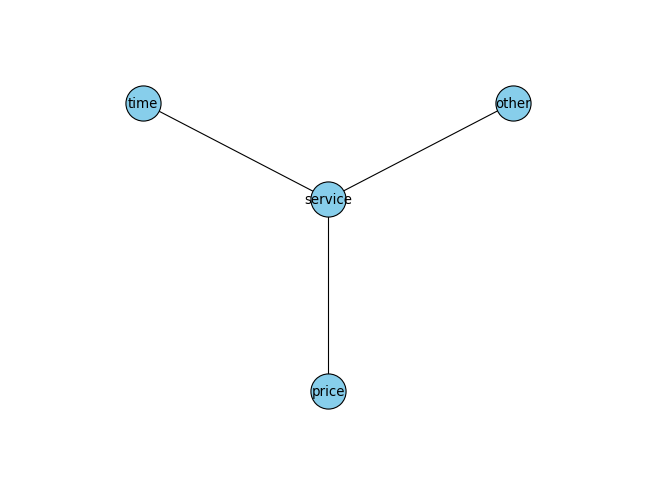

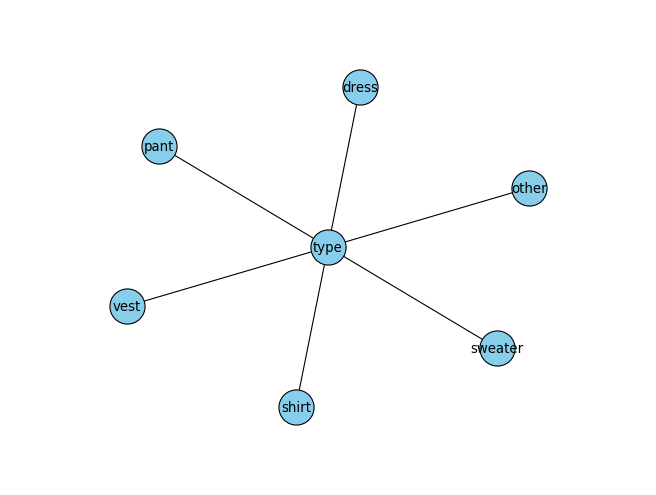

In [19]:
import networkx as nx

for cat in np.unique(df_an['second_cycle'].values):
    df_plot = df_an[df_an['second_cycle'] == cat]
    G = nx.from_pandas_edgelist(df_plot, 'first_cycle', 'second_cycle')
    nx.draw_kamada_kawai(G, with_labels=True, node_color='skyblue', node_size=1000)
    plt.show()

# Add Residu to Data Base (Update Base)

In [20]:
df = df.merge(residu_frame, on='reviewer_id', how='left')

df['aspect'] = df['aspect'].apply(lambda x: ", ".join(list(x)))
df['token_sentence'] = df['token_sentence'].apply(lambda x: ", ".join(list(x)))

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewer_id     100 non-null    int64 
 1   review          100 non-null    object
 2   summarize       100 non-null    object
 3   aspect          100 non-null    object
 4   token_sentence  100 non-null    object
 5   token_lemma     100 non-null    object
 6   rating          100 non-null    int64 
 7   residu          100 non-null    object
dtypes: int64(2), object(6)
memory usage: 6.4+ KB
None


,reviewer_id,review,summarize,aspect,token_sentence,token_lemma,rating,residu
0,0,So flattering and so comfortable! I am in love...,So flattering and so comfortable! I am in lov...,"beige sandal, casual look, compliment, left si...","It has a relaxed fit style as described, and I...",it have a relaxed fit style as described.\nand...,5,"more item, profile, grocery, beige sandal, cro..."
1,1,"Cute but It Pills Great color and pattern, wit...","Material began to pill after first wearing, a...","great color, material, slouchy look, wash cycl...","Cute but It Pills Great color and pattern, wit...",cute but it pill great color and pattern.\nwit...,3,"first washing, wash cycle, slouchy look, hand ..."
2,2,It fell apart after one wash One set fell apar...,One set fell apart after one wash . Threads c...,"bad thing, string, set, thread, product info, ...",It fell apart after one wash One set fell apar...,it fell apart after one wash one set fell apar...,1,"tie, product info, bad thing, string, set"
3,3,"Comfortable, nice color, but LOTS of pilling. ...","Comfortable, nice color, but lots of pilling ...","purchase, good care, nice color, fit, fabric, ...","nice color, I like the fit, weight, I would ha...",nice color.\ni like the fit.\nweight.\ni would...,3,"weight, thats, good care"
4,4,"Cute dress that.even a short, skinny old woman...","Cute dress that.even a short, skinny old woma...","necessary spot, material, old woman, woman ski...","Cute dress that.even a short, skinny old woman...",cute dress that.even a short.\nskinny old woma...,5,"dress that.even, old woman, woman skinny, nece..."


# Save Important Files

In [21]:
result.to_csv("./clothes_result/nodes_clothes.csv", index=False)

In [22]:
df.to_csv("./clothes_result/base_clothes_v1.csv", index=False)

In [23]:
with open("./clothes_result/map_second_clothes.json", 'w') as file:
    json.dump(map_second_code, file)
    
with open("./clothes_result/map_category_clothes.json", "w") as file:
    json.dump(map_categorizing, file)
    
with open("./clothes_result/list_first_cycle_clothes.json", "w") as file:
    json.dump(list_first_cycle, file)